In [60]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
from math import log2
import collections

In [3]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit


def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    layers = int(log2(len(qubits)))
    num_params = layers * (15 + 6)
    i = 0
    symbols = sympy.symbols('qconv0:%d'%num_params)

    source = 0
    remaining = len(qubits)
    for l in range(layers):
        model_circuit += quantum_conv_circuit(qubits[source:], symbols[i:i + 15])
        if len(qubits) - source == 2:
            model_circuit += quantum_pool_circuit([qubits[-2]], [qubits[-1]], symbols[i + 15:i + 21])
        else:
            model_circuit += quantum_pool_circuit(qubits[source:source+remaining],qubits[source+remaining:], symbols[i+15:i+21])
        i += 21
        source += (len(qubits) - source) // 2
        remaining = (len(qubits) - source) // 2
    
    return model_circuit


In [4]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        orig_x[tuple(x.flatten())] = x
        mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
        x = orig_x[flatten_x]
        labels = mapping[flatten_x]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(next(iter(labels)))
        else:
            pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    #print("Number of unique images:", len(mapping.values()))
    #print("Number of unique 3s: ", num_uniq_3)
    #print("Number of unique 6s: ", num_uniq_6)
    #print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    #print()
    #print("Initial number of images: ", len(xs))
    #print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [5]:
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(image.shape[0], image.shape[0])
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        circuit.append(cirq.X(qubits[i])**value)
    return circuit

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x, y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

x_train_4, y_train_4 = remove_contradicting(tf.image.resize(x_train, (4,4)).numpy(), y_train)
x_test_4, y_test_4 = remove_contradicting(tf.image.resize(x_test, (4,4)).numpy(), y_test)

x_train_3, y_train_3 = remove_contradicting(tf.image.resize(x_train, (3,3)).numpy(), y_train)
x_test_3, y_test_3 = remove_contradicting(tf.image.resize(x_test, (3,3)).numpy(), y_test)

x_train_2, y_train_2 = remove_contradicting(tf.image.resize(x_train, (2,2)).numpy(), y_train)
x_test_2, y_test_2 = remove_contradicting(tf.image.resize(x_test, (2,2)).numpy(), y_test)

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [7]:
x_train_circ_2 = [convert_to_circuit(x) for x in x_train_2]
x_test_circ_2 = [convert_to_circuit(x) for x in x_test_2]

x_train_circ_3 = [convert_to_circuit(x) for x in x_train_3]
x_test_circ_3 = [convert_to_circuit(x) for x in x_test_3]

x_train_circ_4 = [convert_to_circuit(x) for x in x_train_4]
x_test_circ_4 = [convert_to_circuit(x) for x in x_test_4]

In [8]:
qubits = cirq.GridQubit.rect(1, 4)
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(create_model_circuit(qubits), [cirq.Z(qubits[-1])]),
])

qubits = cirq.GridQubit.rect(1, 9)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(create_model_circuit(qubits), [cirq.Z(qubits[-1])]),
])

qubits = cirq.GridQubit.rect(1, 16)
model_4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(create_model_circuit(qubits), [cirq.Z(qubits[-1])]),
])

In [61]:
def opt_loop(model, train, test, label_tr, label_ts):
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    tr = []
    ts = []
    h = tf.keras.losses.Hinge()
    #h = tf.keras.losses.MeanSquaredError()
    for i in range(20):
        #if i % 10 == 0:
        #    print(i)
        with tf.GradientTape() as tape:
            preds = model(train)
            loss = h(label_tr, preds)
        
        grads = tape.gradient(loss, model.trainable_variables)
        test_loss = h(label_ts, model(test))
        opt.apply_gradients(zip(grads, model.trainable_variables))
        tr.append(loss)
        ts.append(test_loss)
    
    return tr, ts

In [62]:
qs_plt = [4, 9, 16]
train = 100
test = 200

train_loss_2, test_loss_2 = opt_loop(model_2, tfq.convert_to_tensor(x_train_circ_2[:train]), \
                                     tfq.convert_to_tensor(x_train_circ_2[train:train + test]), \
                                        y_train_2[:train], y_train_2[train:train + test])

train_loss_3, test_loss_3 = opt_loop(model_3, tfq.convert_to_tensor(x_train_circ_3[:train]), \
                                     tfq.convert_to_tensor(x_train_circ_3[train:train + test]), \
                                        y_train_3[:train], y_train_3[train:train + test])

#train_loss_4, test_loss_4 = opt_loop(model_4, tfq.convert_to_tensor(x_train_circ_4[:train]), \
#                                     tfq.convert_to_tensor(x_train_circ_4[train:train + test]), \
#                                        y_train_4[:train], y_train_4[train:train + test])

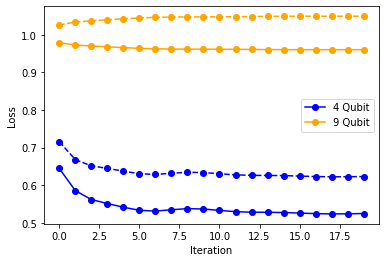

In [63]:
plt.plot(train_loss_2, marker='o', color='blue', label='4 Qubit')
plt.plot(test_loss_2, marker='o', linestyle='--', color='blue')

plt.plot(train_loss_3, marker='o', color='orange', label='9 Qubit')
plt.plot(test_loss_3, marker='o', linestyle='--', color='orange')

#plt.plot(train_loss_4, marker='o', color='green', label='16 Qubit')
#plt.plot(test_loss_4, marker='o', linestyle='--', color='green')

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

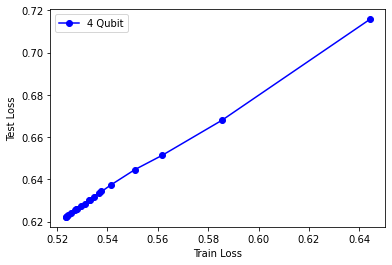

In [66]:
plt.plot(train_loss_2, test_loss_2, marker='o', color='blue', label='4 Qubit')
#plt.plot(train_loss_3, test_loss_3, marker='o', color='orange', label='9 Qubit')
plt.ylabel("Test Loss")
plt.xlabel("Train Loss")
plt.legend()
plt.show()

In [40]:
data_sizes = [5, 10, 20, 40, 60, 80, 100]
train_results = []
test_results = []
test = 200

for train in data_sizes:
    print(train)
    train_loss = []
    test_loss = []
    for i in range(3):
        
        trl, tsl = opt_loop(model_2, tfq.convert_to_tensor(x_train_circ_2[:train]), \
                                             tfq.convert_to_tensor(x_train_circ_2[train:train + test]), \
                                                y_train_2[:train], y_train_2[train:train + test])
        train_loss.append(trl)
        test_loss.append(tsl)
    train_results.append(np.mean(train_loss, axis=0))
    test_results.append(np.mean(test_loss, axis=0))

5
10
20
40
60
80
100


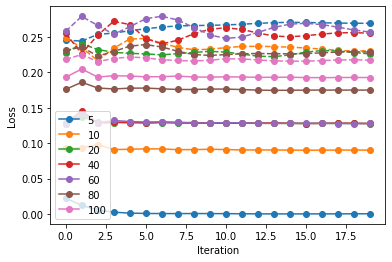

In [59]:
for i, d in enumerate(data_sizes):
    x = plt.plot(train_results[i], marker='o', label=str(d))
    plt.plot(test_results[i], marker='o', linestyle='--', color=x[0].get_color())

plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [42]:
train_results1 = np.array(train_results)
test_results1 = np.array(test_results)
gen_errors = [np.mean(np.abs(train_results1[i] - test_results1[i])) for i in range(len(data_sizes))]

In [57]:
def f(x):
    return 0.5/np.sqrt(x)

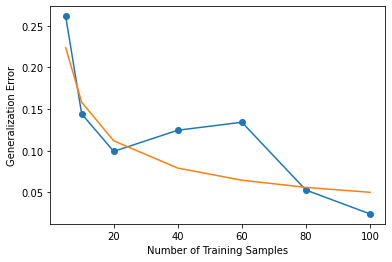

In [58]:
plt.plot(data_sizes, gen_errors, marker='o')
plt.plot(data_sizes, f(data_sizes))
plt.ylabel("Generalization Error")
plt.xlabel("Number of Training Samples")
plt.show()